**Import dependencies**

In [115]:
#!pip install scikit-fuzzy
!pip install simpful

In [205]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import segment
import fit
from scipy.stats import linregress, iqr
import numpy as np
import skfuzzy as fuzz # requires pip install
import simpful as sf # requires pip install
import matplotlib.pyplot as plt
import operator
import statistics

In [203]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

with open("example_data/16265-normalecg.txt") as f:
    file_lines = f.readlines()

data = [float(x.split("\t")[2].strip()) for x in file_lines[100:320]]

max_error = 0.005

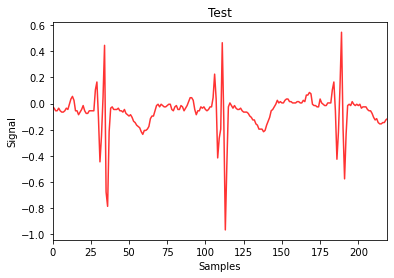

In [14]:
figure()
draw_plot(data, plot_title = 'Test')

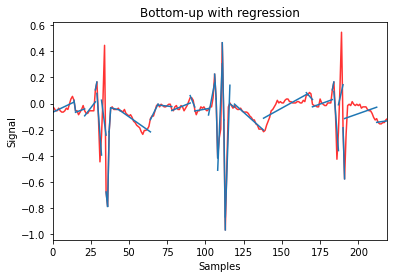

In [7]:
figure()
segments = segment.bottomupsegment(data, fit.regression, fit.sumsquared_error, max_error)
draw_plot(data,"Bottom-up with regression")
draw_segments(segments)

<Figure size 432x288 with 0 Axes>

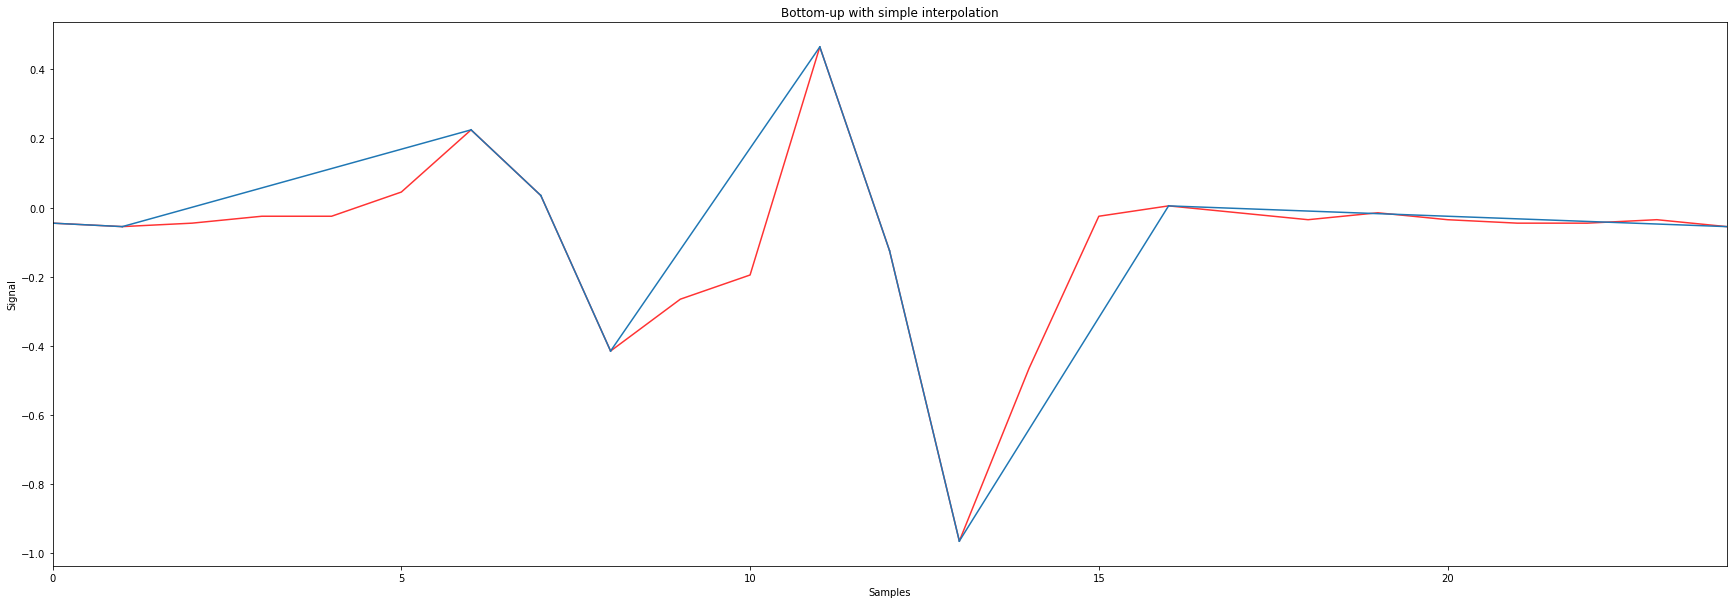

In [222]:
#bottom-up with  simple interpolation
figure()
plt.figure(figsize=(30,10))
segments = segment.bottomupsegment(data[100:125], fit.interpolate, fit.sumsquared_error, max_error)
draw_plot(data[100:125],"Bottom-up with simple interpolation")
draw_segments(segments)

**Calculate Segments**

In [84]:
def slope(series):
    slope_series = []
    for segment in series:
        start, start_val, end, end_val = segment
        slope = (end_val-start_val)/(end-start)
        slope_series.append(slope)
    return slope_series

**Trend Analysis**

In [211]:
# calculate segment specific slope
# output values are between -1 and 1

def slope(series):
    '''
    1. Input segment series.
    2. Return angle of slope.
    '''
    slope_series = []
    for segment in series:
        x0, y0, x1, y1 = segment
        angle = round((np.rad2deg(np.arctan2(y1 - y0, x1 - x0))), 2)
        slope_series.append(angle)
    return slope_series

#def slope(series):
#    '''
#    1. Input segment series.
#    2. Return slope between these two points.
#    '''
#    slope_series = []
#    for segment in series:
#        start, start_val, end, end_val = segment
#        slope = round((end_val-start_val)/(end-start), 4)
#        slope_series.append(slope)
#    return slope_series

# calculate duration
def duration(series):
    '''
    1. Input segment series.
    2. Return segment-specific duration.
    '''
    duration_series = []
    for segment in series:
        start, _, end, _ = segment
        length = end-start
        duration_series.append(length)
    return duration_series


# calculate variability
def segment_variability(data, segments):
    '''
    1. Input value range as array.
    2. Return interquartile range.
    '''
    variability_series = []
    for segment in segments:
        start, _, end, _ = segment
        x = np.array(data[start:end+1])
        segment_iqr = round(iqr(x), 4)
        variability_series.append(segment_iqr)
    return variability_series

# calculate variability
#def variability(value_range):
#    '''
#    1. Input value range as array.
#    2. Return interquartile range.
#    '''
#    x = np.array(value_range)
#    iqr = round(iqr(x), 4)
#    return iqr

**Fuzzy logic**

In [191]:
#slope(segments)

def standardisation(series):
    mean = round(statistics.mean(series), 2)
    sd = round(statistics.stdev(series), 2)
    
    standardisation_series = []
    for segment_value in series:
        val = round(((segment_value - mean) / sd), 2)
        standardisation_series.append(val)
    return standardisation_series

def categorise_slope(series):
    '''
    1. Input segment-specific slopes.
    2. Return dict of slope categories.
    '''
    dynamic_of_change = {
    'quickly increasing' : 0,
    'increasing' : 0,
    'slowly increasing' : 0,
    'constant' : 0,
    'slowly decreasing' : 0,
    'decreasing' : 0,
    'quickly decreasing' : 0}
    for segment in series:
        if segment <= np.quantile(series, 1/7):
            dynamic_of_change['quickly decreasing'] += 1
        if segment > np.quantile(series, 1/7) and segment <= np.quantile(series, 2/7):
            dynamic_of_change['decreasing'] += 1
        if segment > np.quantile(series, 2/7) and segment <= np.quantile(series, 3/7):
            dynamic_of_change['slowly decreasing'] += 1
        if segment > np.quantile(series, 3/7) and segment <= np.quantile(series, 4/7):
            dynamic_of_change['constant'] += 1
        if segment > np.quantile(series, 4/7) and segment <= np.quantile(series, 5/7):
            dynamic_of_change['slowly increasing'] += 1
        if segment > np.quantile(series, 5/7) and segment <= np.quantile(series, 6/7):
            dynamic_of_change['increasing'] += 1
        if segment > np.quantile(series, 6/7):
            dynamic_of_change['quickly increasing'] += 1
    
    return dynamic_of_change

def categorise_duration(series):
    '''
    1. Input segment-specific durations.
    2. Normalise input via standard normalisation.
    3. Return dict of duration categories.
    '''
    dynamic_of_change = {
    'quickly increasing' : 0,
    'increasing' : 0,
    'slowly increasing' : 0,
    'constant' : 0,
    'slowly decreasing' : 0,
    'decreasing' : 0,
    'quickly decreasing' : 0}
    for segment in series:
        if segment < 0 and segment > -0.25:
            dynamic_of_change['slowly decreasing'] += 1
        if segment < -0.25 and segment > -0.5:
            dynamic_of_change['decreasing'] += 1
        # ...
    
    return dynamic_of_change

def describe_slope(slope_dict):
    '''
    1. Input dict of slope categories.
    2. Return sentence.
    '''
    predicate = 'most trends are '
    var = str(max(slope_dict, key = dynamic_of_change.get))
    eos = '.'
    return predicate + var + eos

def quantity_in_agreement(aggregation):
    '''
    1. Input component of trend analysis (e.g. duration).
    2. Output distribution of categorisation in linguistic form.
    '''
    for 

In [229]:
dynamic_of_change

{'quickly increasing': 0,
 'increasing': 0,
 'slowly increasing': 0,
 'constant': 0,
 'slowly decreasing': 13,
 'decreasing': 2,
 'quickly decreasing': 0}

In [233]:
13/15

0.8666666666666667

In [239]:
def quantity_in_agreement(categorisation_dict):

    total = 0

    for value in categorisation_dict.values():
        total += value

    candidate = max(categorisation_dict, key = categorisation_dict.get)
    #print(candidate)

    quantifier = {
    'Almost all of' : 0,
    'Most of' : 0,
    'At least a half of' : 0,
    'Some of' : 0,
    'None of' : 0
    }

    if round((categorisation_dict.get(candidate) / total), 2) > 0.85:
        quantifier['Almost all of'] += 1
    if round((categorisation_dict.get(candidate) / total), 2) > 0.7:
        quantifier['Most of'] += 1
    if round((categorisation_dict.get(candidate) / total), 2) > 0.5:
        quantifier['At least a half of'] += 1
    if round((categorisation_dict.get(candidate) / total), 2) > 0:
        quantifier['Some of'] += 1
    if round((categorisation_dict.get(candidate) / total), 2) == 0:
        quantifier['None of'] += 1

    result = max(quantifier, key = quantifier.get)

    return result  

In [240]:
quantity_in_agreement(dynamic_of_change)

'Almost all of'

In [129]:
'most trends are ' + max(dynamic_of_change, key = dynamic_of_change.get) + '.'

'most trends are slowly decreasing.'

**Fuzzy sets**

In [ ]:
dynamic_of_change = {
    'quickly increasing' : 0,
    'increasing' : 0,
    'slowly increasing' : 0,
    'constant' : 0,
    'slowly decreasing' : 0,
    'decreasing' : 0,
    'quickly decreasing' : 0
}

duration = {
    'very long' : 0,
    'long' : 0,
    'medium' : 0,
    'short' : 0,
    'very short' : 0
}

variability = {
    'very high' : 0,
    'high' : 0,
    'medium' : 0,
    'low' : 0,
    'very low' : 0
}



In [114]:
x = np.arange(0, 1)
x = np.ascontiguousarray(x, dtype=np.float32)
min(x)

0.0

In [ ]:
# Generate universe variables
#   * Quality and service on subjective ranges [0, 10]
#   * Tip has a range of [0, 25] in units of percentage points
# x_qual = np.arange(0, 11, 1)
# x_serv = np.arange(0, 11, 1)
# x_tip  = np.arange(0, 26, 1)

x_duration = np.arange(0, 101) 
x_variability = np.arange(0, 4)
x_change = np.arange(-1, 1)

# Generate fuzzy membership functions
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])
qual_md = fuzz.trimf(x_qual, [0, 5, 10])
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])
serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])
tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])


In [ ]:
# P summarizer, an attribute together with a linguistic value (fuzzy predicate) defined on the domain of attribute A
# (e.g. 'low salary' for attribute salary)

# Q quantity agreement
# i.e. a linguistic quantifier (e.g. most)

# R qualifier
# i.e another attribute together with a linguistic value (fuzzy predicate) defined on the domain of attribute A
# determining a fuzzy subset of Y (e.g. 'young' for attribute 'age')



**Improvements**

In [ ]:
# Error of selected approximation compared to ground truth
# Incoporating ground truth (T)
# Normalise (each slope, subtract mean and divide by standard deviation of all slopes)